source: https://www.coursera.org/learn/introduction-tensorflow/home/welcome

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
import seaborn as sns
sns.set_theme(style='whitegrid')
sns.set(rc={'figure.figsize':(12.5,6)})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/drive/My\ Drive/foo.txt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Hello Google Drive!

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
#load data from folder
filepath = 'drive/My Drive/MSc WIN/05_HS2020/VMAT/Data/final_df.csv'
df=pd.read_csv(filepath)
series=df[['shelter']]

#transform dataframe into Numpy Array
series=df.shelter.to_numpy()
time = np.arange(series.size, dtype="float32")

In [ ]:
#regular Split of Train & Validation set to test for model robustness
train_size = 0.8
split_time = round(series.size*train_size)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 5
batch_size = 20
shuffle_buffer_size = 2500

In [ ]:
print(time_train.shape,
x_train.shape,time_valid.shape,x_valid.shape)

(2479,) (2479,) (620,) (620,)


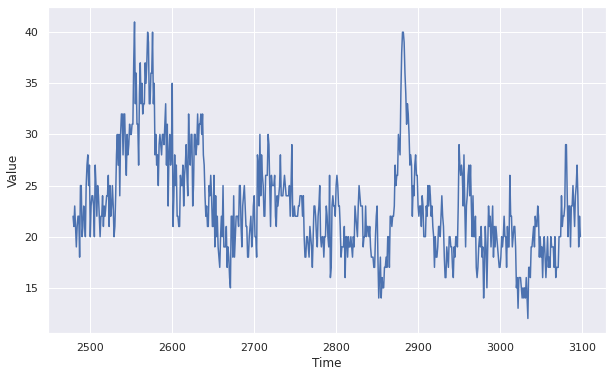

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [ ]:
# preprocess windowed datasets (x= window, y=label)
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
#call preprocessor method
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

#define & compile model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

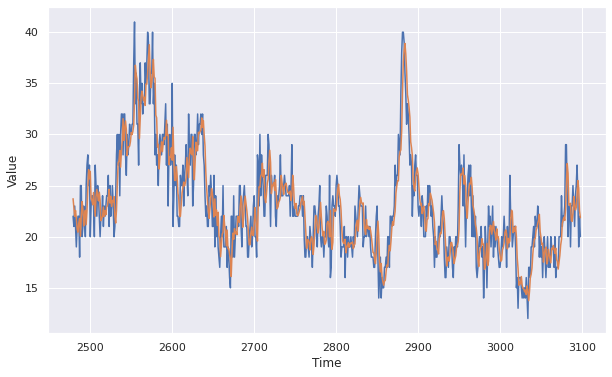

In [ ]:
#predict 
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast_x = forecast[split_time-window_size:]
results = np.array(forecast_x)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

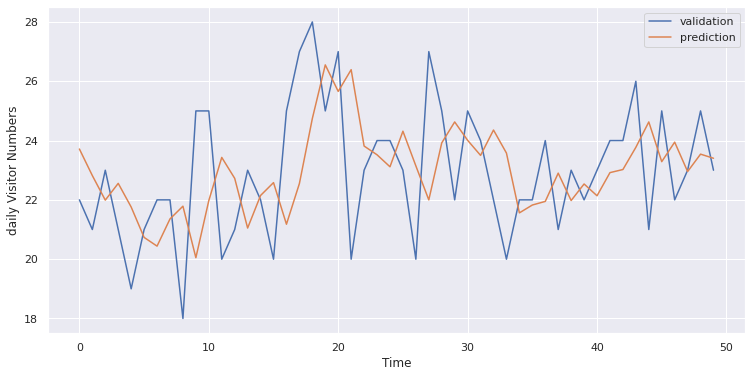

In [ ]:
plt.plot(time_train[:50], x_valid[:50],label='validation')
plt.plot(time_train[:50], results[:50],label='prediction')
plt.ylabel('daily Visitor Numbers')
plt.xlabel('Time')
plt.legend()

No handles with labels found to put in legend.


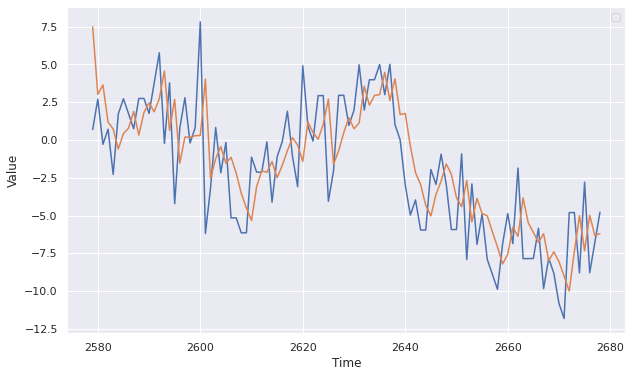

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid[100:200], x_valid[100:200])
plot_series(time_valid[100:200], results[100:200])

plt.legend()

In [ ]:
print('MAE: ',tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print('MAPE: ',tf.keras.metrics.mean_absolute_percentage_error(x_valid, results).numpy())

MAE:  2.0216544
MAPE:  107.80424


In [ ]:
#investigating model performance only when looking at outliers outside the 75% / 25% quartile
pred_val=pd.DataFrame(x_valid, results).reset_index()
pred_val=pred_val.rename(columns={'index':'prediction',0:'validation'})
pred_val.describe()

outliers=pred_val.loc[(pred_val.prediction <= 19.863779) | (pred_val.prediction >= 25.079701)]

print('MAE: ',tf.keras.metrics.mean_absolute_error(outliers.validation, outliers.prediction).numpy())
print('MAPE: ',tf.keras.metrics.mean_absolute_percentage_error(outliers.validation, outliers.prediction).numpy())

MAE:  2.021654154288044
MAPE:  107.80423354392164


NameError: ignored

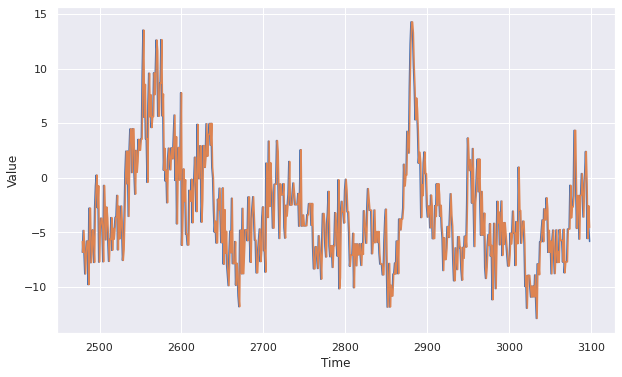

In [ ]:
#naive forecasting as baseline -> previous day shift -1
naiv_pred = np.roll(x_valid,-1)
naive_mae=np.mean(tf.keras.losses.mean_absolute_error(x_valid, naiv_pred))
naiv_mape=np.mean(tf.keras.losses.mean_absolute_percentage_error(x_valid, naiv_pred))

plt.figure(figsize=(10, 6))
plot_series(time_valid, naiv_pred)
plot_series(time_valid, x_valid)
print('MAE: ',x)